In [102]:
import re
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [39]:
# загружаем исходные данные
data = pd.read_csv('./data/Groceries_dataset.csv')
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [20]:
# проверяем данные на наличие пропусков
is_nan = data.isna().sum()
is_nan

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [23]:
# посмотрим на группы товаров
Frequency_of_items = data.groupby(pd.Grouper(key='itemDescription')).size().reset_index(name='count')
fig = px.treemap(Frequency_of_items, path=['itemDescription'], values='count')
fig.update_layout(title_text='Количество проданных товаров',
                  title_x=0.5, title_font=dict(size=18))
fig.update_traces(textinfo="label+value")
fig.show()

In [31]:
# группируем покупки по корзинам товаров
data.itemDescription = data.itemDescription.transform(lambda x: [x])
data = data.groupby(['Member_number','Date']).sum()['itemDescription'].reset_index(drop=True)
data.head()

0    [sausage, whole milk, semi-finished bread, yog...
1                    [whole milk, pastry, salty snack]
2                       [canned beer, misc. beverages]
3                          [sausage, hygiene articles]
4                           [soda, pickled vegetables]
Name: itemDescription, dtype: object

In [34]:
# приводим данные к формату, который принимает функция apriori
# itemDescription в данном случае это наши категориальные признаки
# каждая строка это транзакция
encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(data).transform(data), columns=encoder.columns_)
transactions.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
# frequent_itemsets - частые наборы данных
# rules - наборы данных
# min_support - минимальная поддержка. Подмножество не является частным если:
### P(I) < min_support, где I — любой непустой набор элементов
### Любое подмножество в наборе элементов имеет значение меньше минимальной поддержки
frequent_itemsets = apriori(transactions, min_support=6/len(data), use_colnames=True, max_len=2).sort_values(by="support")
print('Frequent itemsets:')
display(frequent_itemsets.head(10))
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5).sort_values('lift', ascending=False)
print('Rules:')
print('antecedents - посылка')
print('consequents - следствие')
display(rules.head(10))
print("Rules identified: ", len(rules))

Frequent itemsets:


,support,itemsets
1522,0.0002,"(dental care, fruit/vegetable juice)"
1725,0.0002,"(finished products, fruit/vegetable juice)"
537,0.0002,"(semi-finished bread, bottled beer)"
544,0.0002,"(specialty cheese, bottled beer)"
545,0.0002,"(specialty chocolate, bottled beer)"
1711,0.0002,"(domestic eggs, turkey)"
1708,0.0002,"(spread cheese, domestic eggs)"
1707,0.0002,"(specialty fat, domestic eggs)"
1705,0.0002,"(specialty cheese, domestic eggs)"
1726,0.0002,"(finished products, newspapers)"


Rules:
antecedents - посылка
consequents - следствие


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
567,(soups),(seasonal products),0.003208,0.007084,0.000334,0.104167,14.704206,0.000311,1.108371
566,(seasonal products),(soups),0.007084,0.003208,0.000334,0.047170,14.704206,0.000311,1.046138
142,(cookware),(oil),0.001136,0.014903,0.000200,0.176471,11.840939,0.000184,1.196189
143,(oil),(cookware),0.014903,0.001136,0.000200,0.013453,11.840939,0.000184,1.012485
258,(roll products ),(rice),0.005480,0.003275,0.000200,0.036585,11.171976,0.000183,1.034576
259,(rice),(roll products ),0.003275,0.005480,0.000200,0.061224,11.171976,0.000183,1.059380
86,(curd cheese),(mustard),0.003074,0.006148,0.000200,0.065217,10.607042,0.000182,1.063190
87,(mustard),(curd cheese),0.006148,0.003074,0.000200,0.032609,10.607042,0.000182,1.030530
144,(liver loaf),(condensed milk),0.003342,0.006549,0.000200,0.060000,9.161020,0.000179,1.056862
145,(condensed milk),(liver loaf),0.006549,0.003342,0.000200,0.030612,9.161020,0.000179,1.028132


Rules identified:  768


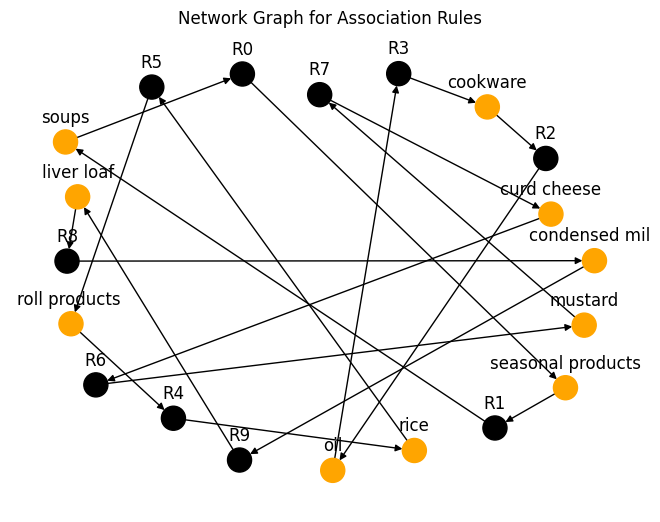

In [65]:
# визуализируем связь между продуктами в виде графа
def draw_graph(rules, rules_count):
    network = nx.DiGraph()

    for i in range(rules_count):
        # добавление узла правила
        network.add_nodes_from(['R' + str(i)])
        for antecedents in rules.iloc[i]['antecedents']:
            # Добавление узла-предшественника и ссылки на правило
            network.add_nodes_from([antecedents])
            network.add_edge(antecedents, 'R' + str(i),  weight=2)
            for consequents in rules.iloc[i]['consequents']:
                # Добавление узла-последователя и ссылки на правило
                network.add_nodes_from([consequents])
                network.add_edge('R' + str(i), consequents,  weight = 2)

    color_map=[]  
  
    # Для каждого узла, если это правило, цвет черный, в противном случае - оранжевый.
    for node in network:
        if re.compile(r'^[R]\d+$').fullmatch(node) != None:
            color_map.append('black')
        else:
            color_map.append('orange')
  
    # Расположение узлов с помощью spring layout
    pos = nx.spring_layout(network, k=16, scale=1)
    # Построение сетевого графа
    nx.draw(network, pos, node_color = color_map, font_size=8)            
  
    # Сдвиг расположения текста вверх
    for p in pos:  
        pos[p][1] += 0.12

    nx.draw_networkx_labels(network, pos)
    plt.title('Network Graph for Association Rules')
    plt.show()

draw_graph(rules, 10)

Milk:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957
1,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523
2,(syrup),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908
3,(canned fruit),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908
4,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,0.000229,1.162868


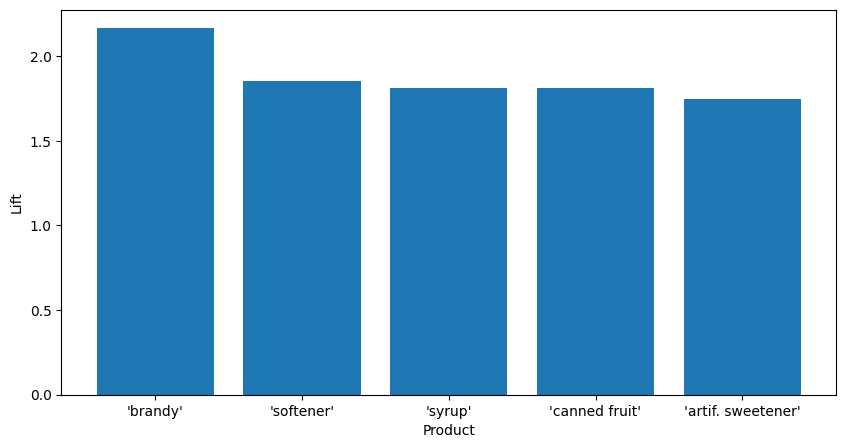

Soda:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(artif. sweetener),(soda),0.001938,0.097106,0.000468,0.241379,2.485725,0.000280,1.190178
1,(spices),(soda),0.002673,0.097106,0.000601,0.225000,2.317051,0.000342,1.165024
2,(snack products),(soda),0.001804,0.097106,0.000334,0.185185,1.907038,0.000159,1.108097
3,(nut snack),(soda),0.001470,0.097106,0.000267,0.181818,1.872364,0.000125,1.103537
4,(bathroom cleaner),(soda),0.001136,0.097106,0.000200,0.176471,1.817295,0.000090,1.096371


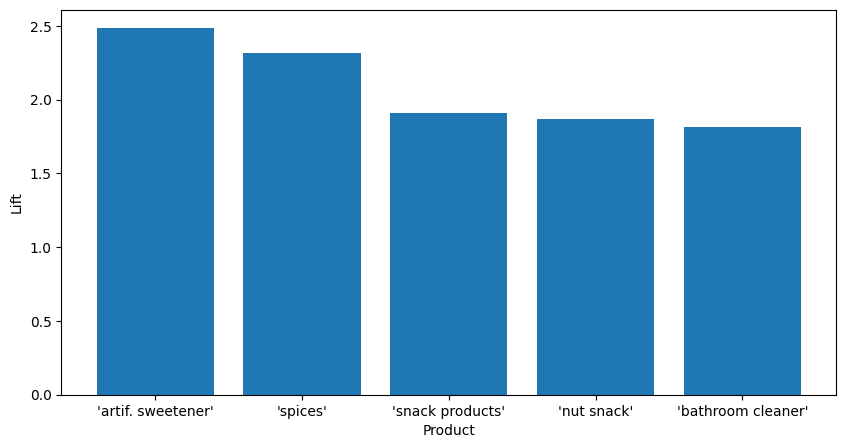

Beef:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(specialty fat),(beef),0.001938,0.03395,0.000200,0.103448,3.047040,0.000135,1.077517
1,(candles),(beef),0.004411,0.03395,0.000267,0.060606,1.785135,0.000118,1.028375
2,(pet care),(beef),0.005681,0.03395,0.000334,0.058824,1.732631,0.000141,1.026428
3,(pasta),(beef),0.008087,0.03395,0.000468,0.057851,1.703992,0.000193,1.025368
4,(processed cheese),(beef),0.010158,0.03395,0.000535,0.052632,1.550249,0.000190,1.019719


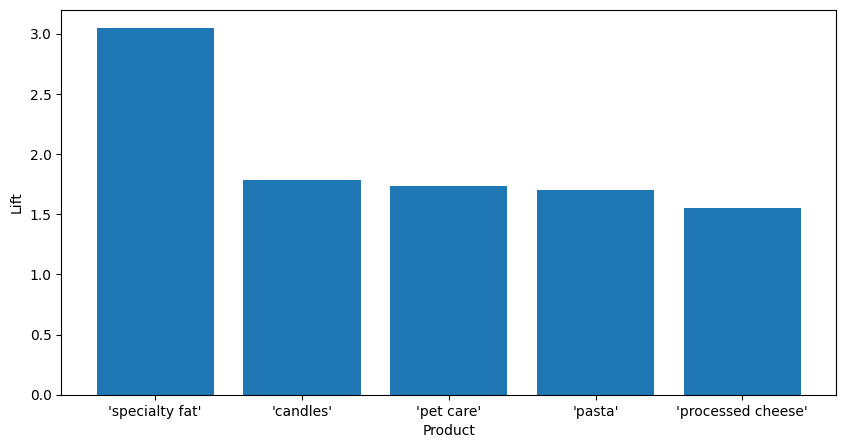

In [119]:
# посмотрим какие продукты стимулируют продажи других продуктов
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]
milk_rules = milk_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

soda_rules = rules[rules['consequents'].astype(str).str.contains('soda')]
soda_rules = soda_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

beef_rules = rules[rules['consequents'].astype(str).str.contains('beef')]
beef_rules = beef_rules.sort_values(by=['lift'], ascending=[False]).reset_index(drop=True)

print('Milk:')
display(milk_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in milk_rules.head()['antecedents']]
count = np.array(milk_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()

print('Soda:')
display(soda_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in soda_rules.head()['antecedents']]
count = np.array(soda_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()

print('Beef:')
display(beef_rules.head())

groups = [re.search(r'[^frozenset, (, {].*[^}, )]', str(item))[0] for item in beef_rules.head()['antecedents']]
count = np.array(beef_rules.head()['lift'])
plt.figure(figsize=(10, 5))
plt.bar(groups, count)
plt.xlabel('Product')
plt.ylabel('Lift')
plt.show()
